<h1 style='font-size:60px'>
    What is Dask?
<img src='logo.svg' align='left' height='120' width='120' style='float: left; margin-right: 40px; margin-top: 1px;'/>
</h1>

<font size='4'> Henry Wilde | 
<i class='fa fa-github' aria-hidden='false'></i>
<i class='fa fa-twitter' aria-hidden='false'></i> @daffidwilde </font>

## Dask is a parallel computing framework all about building graphs
## Documentation available at [docs.dask.org](https://docs.dask.org)

<br>
<br>

<img align='centre' width='75%' src='dask-overview.svg'>

<br>
<br>

# parellilisation with `dask.delayed`

In [ ]:
from time import sleep


def inc(x):
    sleep(0.5)
    return x + 1


def add(x, y):
    sleep(1)
    return x + y


def mul(x, y):
    sleep(0.5)
    return x * y

In [ ]:
%%time

results = []
a = inc(1)
for i in range(3):
    b = mul(i, a)
    c = add(a, b)
    results.append(c)

total = sum(results)
total

---

In [ ]:
from dask import delayed


@delayed
def inc(x):
    sleep(0.5)
    return x + 1


@delayed
def add(x, y):
    sleep(1)
    return x + y


@delayed
def mul(x, y):
    sleep(0.5)
    return x * y

In [ ]:
%%time

results = []
a = inc(1)
for i in range(3):
    b = mul(i, a)
    c = add(a, b)
    results.append(c)

total = sum(results)

# `numpy`-style linear algebra

In [3]:
%%time
import numpy as np

size = 10_000

rng = np.random.default_rng(0)
A = rng.normal(size=(size, size))

A.mean(), A.std()

CPU times: user 1.44 s, sys: 281 ms, total: 1.73 s
Wall time: 1.72 s


(9.930063662614851e-05, 1.0000146901441476)

---

Dask are currently developing a `np.random.default_rng` mimic [(dask#9038)](https://github.com/dask/dask/pull/9038), so global seeding will have to do!

In [26]:
%%time
import dask
import dask.array as da

da.random.seed(0)
A = da.random.normal(size=(size, size))

results = A.mean(), A.std()
dask.compute(*results)

CPU times: user 6.41 s, sys: 145 ms, total: 6.55 s
Wall time: 527 ms


(-0.00012876610754209474, 1.0000092836720487)

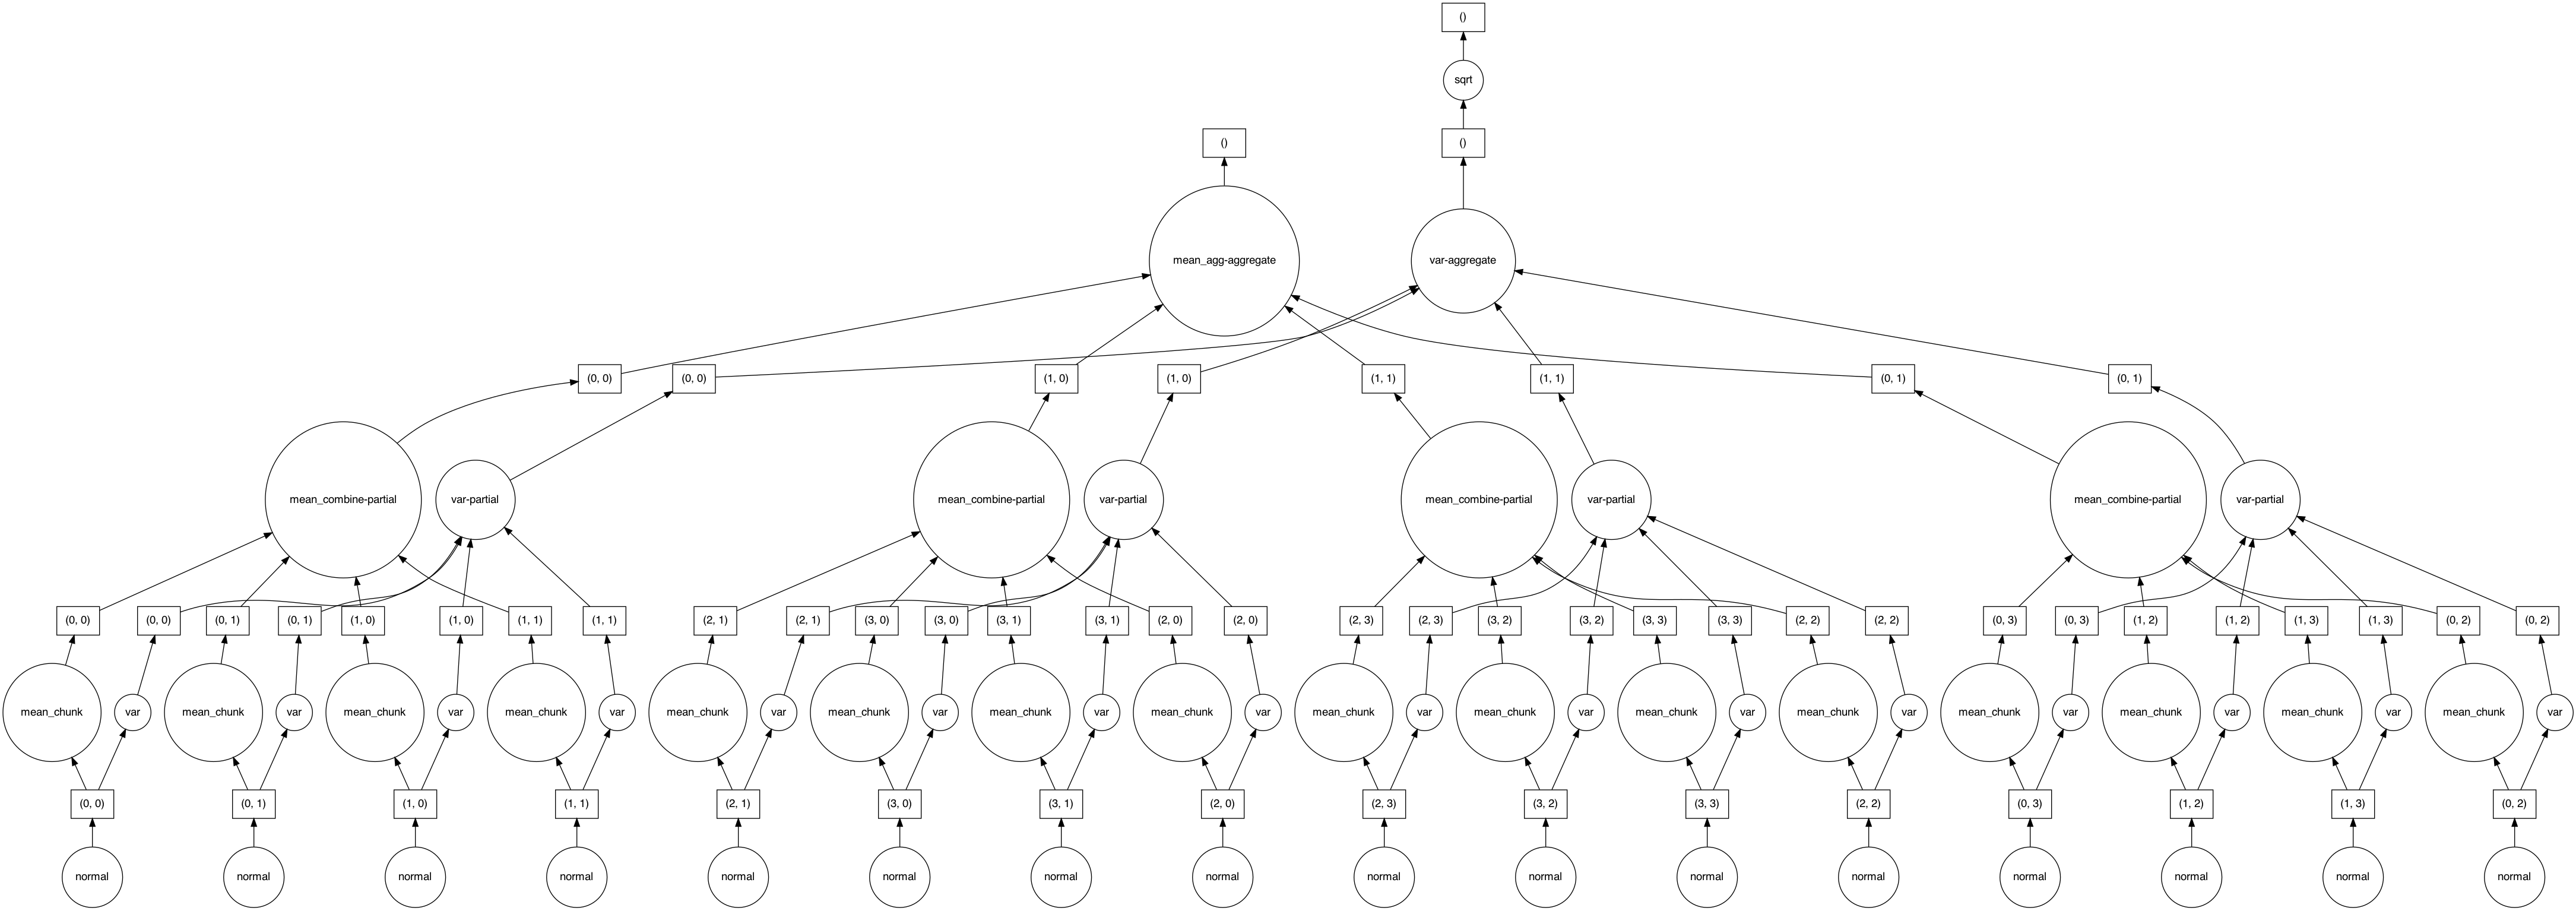

In [24]:
dask.visualize(results)

In [22]:
b = da.random.normal(size=size)

x = da.linalg.solve(A, b)

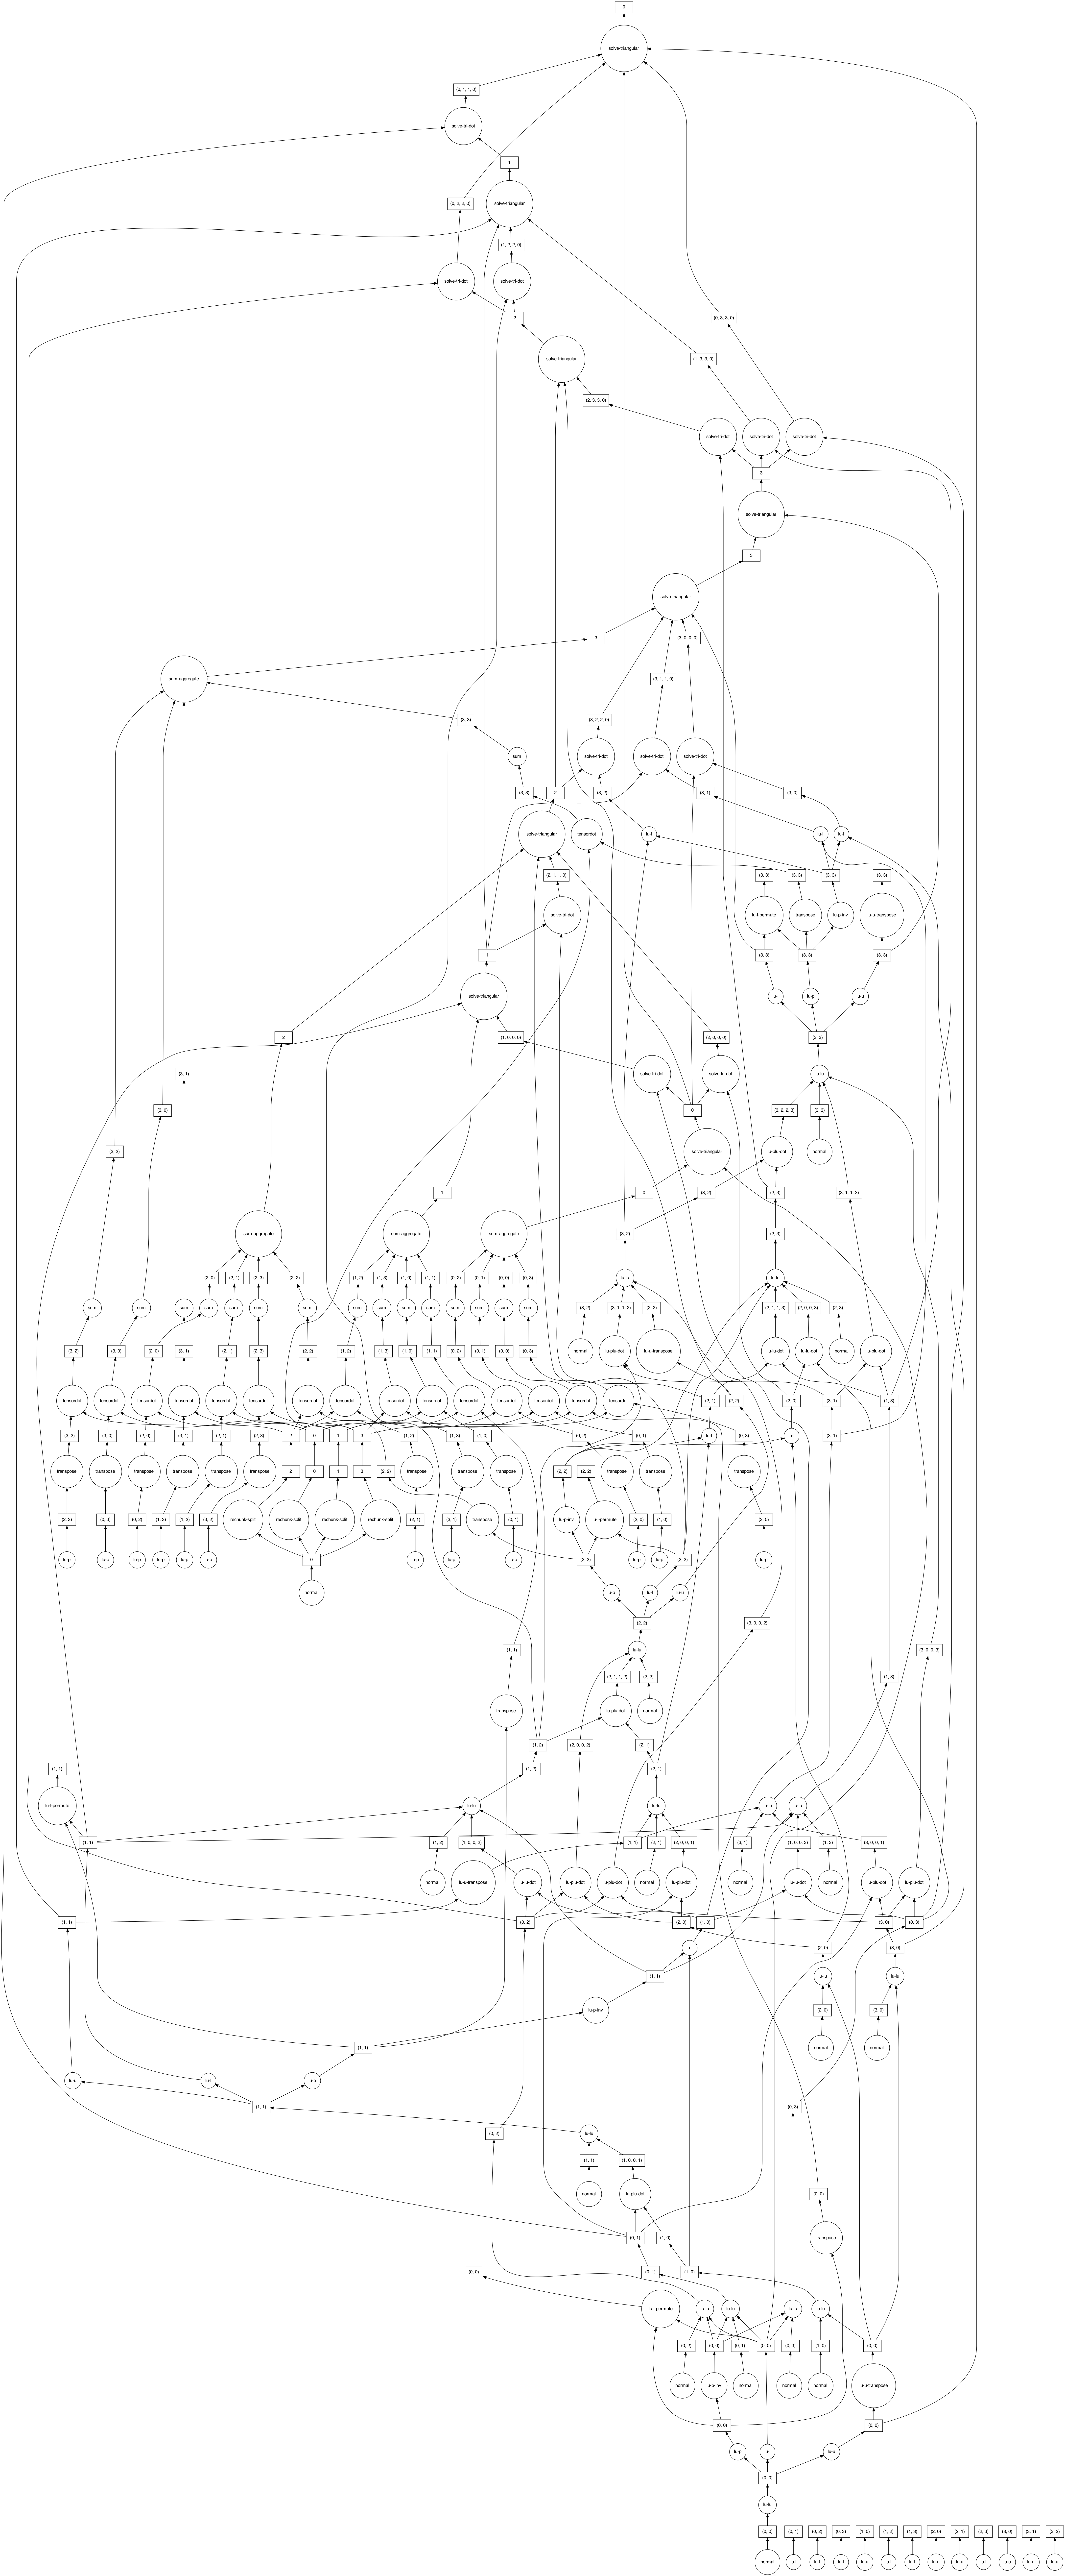

In [23]:
x.visualize(rankd)

# `pandas`-esque data handling

Data available as a tarball [here](https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz) or by running `./get_data.py`

In [ ]:
%%time
import glob
import pandas as pd


dtypes = {
    "CRSElapsedTime": "float",
    "TailNum": "category",
    "UniqueCarrier": "category",
    "Origin": "category",
    "Dest": "category",
}

dfs = (pd.read_csv(csv, dtype=dtypes) for csv in glob.iglob("nycflights/*.csv"))
df = pd.concat(dfs)

In [ ]:
df.memory_usage(deep=True).sum() / (1024**2)

In [ ]:
df.head()

In [ ]:
%%time
df.groupby("Origin")["DepDelay"].mean().sort_values()

---

In [ ]:
%%time
import dask.dataframe as dd


ddf = dd.read_csv("nycflights/*.csv", dtype=dtypes)

In [ ]:
ddf.head()

In [ ]:
mean = ddf.groupby("Origin")["DepDelay"].mean()
mean

In [ ]:
mean.visualize()

In [ ]:
%%time
mean.compute().sort_values()

# Schedulers
---


There are four schedulers currently implemented in Dask:

-  **Threaded:**
 - Useful for numeric code such as `numpy` and `pandas` where the GIL is released 


- **Multiprocessing:**
 - Good for Python-bound code that requires multiple interpreters


- **Synchronous:**
 - Helps with debugging and profiling


- **Distributed:**
 - For working with a cluster of machines on larger tasks
 - Local alternative with better diagnostic tools

In [ ]:
import dask_ml.datasets
import dask_ml.cluster
from distributed import Client

client = Client(n_workers=8, memory_limit="4GiB")
client

In [ ]:
n_clusters = 3

X, _ = dask_ml.datasets.make_blobs(
    n_samples=1e7,
    chunks=1e5,
    n_features=2,
    centers=n_clusters,
    random_state=0,
)

X.persist()
X

In [ ]:
%%time
kmeans = dask_ml.cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(X)
kmeans.labels_

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline


skip = 1000
_, ax = plt.subplots(dpi=300)

plot = ax.scatter(X[::skip, 0], X[::skip, 1], marker=".", c=kmeans.labels_[::skip])

In [ ]:
client.shutdown()